In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



from helper import *

## Import training data and extract categorical features

In [23]:
df = pd.read_csv('../data/train.csv')
#df.head()

In [24]:
categoric_df = df.select_dtypes(exclude=[np.number])
categoric_df['SalePrice'] = df['SalePrice']
print(categoric_df.columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')


In [25]:
categoric_df.drop(['MiscFeature'], axis=1, inplace=True)

'MiscFeature' is the feature of the house not covered in other categories but their is a feature called 'MiscVal' which is the value of the 'MiscFeature'. So, we can drop this feature as it is just a description but the value is already accounted for in numeric_df

## Identify Null Values

In [26]:
count_nulls(categoric_df)

,nulls,percent_missing
PoolQC,1453,0.995205
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
GarageType,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
BsmtExposure,38,0.026027


There are a lot of nulls for Pools, Alleys, Fences, etc in the dataset. However in the description **NA** means No Pool, No Alley, No Fence, etc. So I will replace certain nulls with descriptions in the notes with (str) **'none'** before onehot encoding.

In [ ]:
#electircal should not be na, drop na electorcal row
categoric_df.dropna(subset=['Electrical'], inplace=True)

In [28]:
#remove masonry veneer type col
categoric_df.drop(['MasVnrType'], axis=1, inplace=True)

In [29]:
#apply one hot encoding
categoric_df = pd.get_dummies(categoric_df, drop_first=True)

In [30]:
categoric_df.head()

,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,False,False,True,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
1,181500,False,False,True,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
2,223500,False,False,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,140000,False,False,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,250000,False,False,True,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False


In [31]:
count_nulls(categoric_df)

,nulls,percent_missing


In [32]:
#save to csv
categoric_df['Id'] = df['Id']
categoric_df.drop(columns=['SalePrice']).to_csv('../new_data/clean_train_categoric.csv', index=False)

In [33]:
categoric_df.drop(['Id'], axis=1, inplace=True)

## Create a model using categorical only features

In [34]:
X = categoric_df.drop(columns=['SalePrice'])
y = categoric_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
param_grids = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForestRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]},
    'AdaBoostRegressor': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'BaggingRegressor': {'n_estimators': [10, 50, 100]},
    'ExtraTreesRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'DecisionTreeRegressor': {'max_depth': [None, 10, 20]},
    'KNeighborsRegressor': {'n_neighbors': [3, 5, 10]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR': SVR(),
}

In [36]:
base_model = RandomForestRegressor(random_state=42) 
rfe = RFE(estimator=base_model, n_features_to_select=20, verbose=2)

rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Selected Features:")
print(selected_features)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

results_rfe = {}
best_models_rfe = {}

print('Training models with RFE-selected features...')
for name, model in tqdm(models.items()):
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_rfe, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = np.sqrt(-grid_search.best_score_)  # RMSE

    results_rfe[name] = best_rmse
    best_models_rfe[name] = best_model

print('\nModel Performance with RFE (RMSE):')
for name, rmse in results_rfe.items():
    print(f'{name}: {rmse:.4f}')

print('\nBest Model with RFE:')
best_model_rfe = best_models_rfe[min(results_rfe, key=results_rfe.get)]
print(f'{best_model_rfe}: {results_rfe[min(results_rfe, key=results_rfe.get)]:.4f}')

print(best_model_rfe.get_params())


Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
F

100%|██████████| 11/11 [00:01<00:00,  5.62it/s]


Model Performance with RFE (RMSE):
Ridge: 47349.7172
Lasso: 47353.7454
ElasticNet: 47554.7120
RandomForestRegressor: 46849.4001
GradientBoostingRegressor: 47637.8533
AdaBoostRegressor: 54620.0253
BaggingRegressor: 47347.7818
ExtraTreesRegressor: 53373.7866
DecisionTreeRegressor: 54394.0578
KNeighborsRegressor: 49484.0674
SVR: 79442.6150

Best Model with RFE:
RandomForestRegressor(max_depth=10, n_estimators=200): 46849.4001
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [37]:
if hasattr(best_model, "feature_importances_"):
    feature_importances = zip(X.columns, best_model.feature_importances_)
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    for feature, importance in feature_importances:
        print(f'{feature}: {importance:.4f}')

In [38]:
if hasattr(best_model, "feature_improtances_"):
    plt.figure(figsize=(10, 5))
    colors = cm.viridis([x[1] for x in feature_importances])
    plt.barh([x[0] for x in feature_importances], [x[1] for x in feature_importances], color=colors)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    
    for i, (feature, importance) in enumerate(feature_importances):
        plt.text(importance - 0.001, i, f'{importance:.4f}', ha='right', va='center', color='white')
        
    plt.show()

Total explained variance with selected components: 0.9501
Number of components selected: 85
Training models with PCA-transformed features...


100%|██████████| 11/11 [00:28<00:00,  2.58s/it]



Model Performance with PCA (RMSE):
Ridge: 45373.6681
Lasso: 45892.0479
ElasticNet: 45395.7378
RandomForestRegressor: 48286.3277
GradientBoostingRegressor: 49430.6531
AdaBoostRegressor: 56222.7626
BaggingRegressor: 48793.6664
ExtraTreesRegressor: 47513.5446
DecisionTreeRegressor: 71855.8128
KNeighborsRegressor: 48343.1629
SVR: 76447.4911

Best Model with PCA:
Ridge(alpha=10): 45373.6681
{'alpha': 10, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


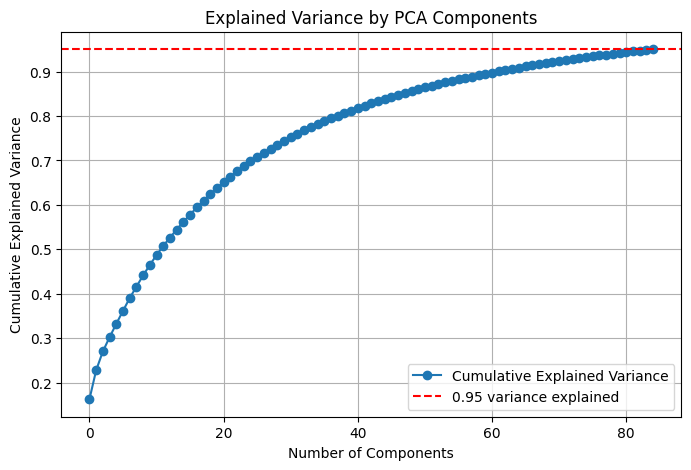

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Total explained variance with selected components: {explained_variance[-1]:.4f}")
print(f"Number of components selected: {pca.n_components_}")

results_pca = {}
best_models_pca = {}

print('Training models with PCA-transformed features...')
for name, model in tqdm(models.items()):
    grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)

    best_model = grid_search.best_estimator_
    best_rmse = np.sqrt(-grid_search.best_score_)  # RMSE

    results_pca[name] = best_rmse
    best_models_pca[name] = best_model

# Display results
print('\nModel Performance with PCA (RMSE):')
for name, rmse in results_pca.items():
    print(f'{name}: {rmse:.4f}')

print('\nBest Model with PCA:')
best_model_pca = best_models_pca[min(results_pca, key=results_pca.get)]
print(f'{best_model_pca}: {results_pca[min(results_pca, key=results_pca.get)]:.4f}')

print(best_model_pca.get_params())

# Visualize explained variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o', label="Cumulative Explained Variance")
plt.axhline(y=explained_variance[-1], color='r', linestyle='--', label=f"{explained_variance[-1]:.2f} variance explained")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.legend()
plt.grid()
plt.show()

In [41]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error

model = Ridge()

param_grid = {'alpha': [0.1, 1, 10, 100]}

sfs = SequentialFeatureSelector(
    model,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train, y_train)

X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_sfs, y_train)

best_model = grid_search.best_estimator_
best_rmse = np.sqrt(-grid_search.best_score_)  # RMSE

print(f'Best Model: {best_model}')
print(f'Best RMSE: {best_rmse:.4f}')
print(best_model.get_params())

selected_features = X.columns[sfs.get_support()]
print(f"Selected Features for Ridge Model: {selected_features}")

Best Model: Ridge(alpha=1)
Best RMSE: 38405.6707
{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Selected Features for Ridge Model: Index(['MSZoning_RM', 'Street_Pave', 'LotShape_Reg', 'LandContour_Low',
       'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_Inside', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       ...
       'GarageQual_Gd', 'GarageCond_TA', 'PoolQC_Fa', 'Fence_GdWo',
       'SaleType_Con', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth',
       'SaleCondition_Alloca', 'SaleCondition_Partial'],
      dtype='object', length=101)
